In [79]:
import torch  
from torch.utils.data import Dataset, DataLoader  
import torchvision.transforms as transforms  
from torchvision.datasets import ImageFolder  
from PIL import Image  
import pathlib  
import cupy as cp 
from torchvision.datasets import ImageFolder
from torchvision import datasets
import torch  
import torch.nn as nn  
import torch.optim as optim  
from PIL import Image

In [80]:
# Verificar la disponibilidad de la GPU  
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') 
print("GPU disponible:", torch.cuda.is_available())
print("Nombre de la GPU:", torch.cuda.get_device_name() if torch.cuda.is_available() else "N/A")


GPU disponible: True
Nombre de la GPU: NVIDIA GeForce RTX 4060


In [81]:
# Definir directorios
directorio_dataset = '../Datasets/CIFAR-10 dos clases'
imagenes_originales = '../Datasets/CIFAR-10 dos clases/cat'
imagenes_corruptas = '../Datasets/CIFAR-10 dos clases/cat_c_defocus_blur'

directorio_dataset = pathlib.Path(directorio_dataset)
imagenes_originales = pathlib.Path(imagenes_originales)
imagenes_corruptas = pathlib.Path(imagenes_corruptas)

# Images dimensions
img_height = 32
img_width = 32
channels = 3
batch_size = 32

# Transformaciones para preprocesamiento de datos
transform = transforms.Compose([
    transforms.Resize((img_height, img_width)),  # Ajustar tamaño a 32x32
    transforms.ToTensor(),  # Convertir a tensor
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalizar
])

class CustomImageDataset(Dataset):
    def __init__(self, directory, transform=None):
        self.directory = pathlib.Path(directory)
        self.transform = transform
        self.images = list(self.directory.glob('*.png'))

    def __len__(self):  
        return len(self.images)  

    def __getitem__(self, idx):  
        img_path = self.images[idx]  
        image = Image.open(img_path).convert('RGB')  
        if self.transform:  
            image = self.transform(image)  
        return image

# Crear datasets personalizados
dataset_completo = datasets.ImageFolder(root=str(directorio_dataset), transform=transform)
dataset_originales = CustomImageDataset(imagenes_originales, transform=transform)
dataset_corruptas = CustomImageDataset(imagenes_corruptas, transform=transform)

# Calcular totales
total_dataset = len(list(directorio_dataset.glob('*/*.png')))
total_originales = len(dataset_originales)
total_corruptas = len(dataset_corruptas)

# Crear el DataLoader para iterar sobre los datos en lotes
dataloader_completo = DataLoader(dataset_completo, batch_size=batch_size, shuffle=False, num_workers=0)
dataloader_originales = DataLoader(dataset_originales, batch_size=batch_size, shuffle=False)
dataloader_corruptas = DataLoader(dataset_corruptas, batch_size=batch_size, shuffle=False)

print(f"Total imágenes dataset: {total_dataset}")  
print(f"Total imágenes originales: {total_originales}")  
print(f"Total imágenes corruptas: {total_corruptas}")

# Get the class names
class_names = dataset_completo.classes
num_classes = len(class_names)

print(f"Número de clases: {num_classes}")
print(f"Los nombres de las clases son: {class_names}")


Total imágenes dataset: 10000
Total imágenes originales: 5000
Total imágenes corruptas: 5000
Número de clases: 2
Los nombres de las clases son: ['cat', 'cat_c_defocus_blur']


In [82]:
def get_transform(channels):   # Aqui define los canales de entrada que se aplicaran al modelo
    if channels == 3:
        # Definir transformaciones para el conjunto de datos en escala a color
        transform = transforms.Compose([
            transforms.Resize((img_height, img_width)),  # Ajustar tamaño
            transforms.ToTensor(),  # Convertir a tensor
            transforms.Normalize((0.5,), (0.5,))  # Normalizar
        ])
    elif channels == 1:
        # Definir transformaciones para el conjunto de datos en escala de grises
        transform = transforms.Compose([
            transforms.Grayscale(),  # Convertir a escala de grises
            transforms.Resize((img_height, img_width)),  # Ajustar tamaño
            transforms.ToTensor(),  # Convertir a tensor
            transforms.Normalize((0.5,), (0.5,))  # Normalizar
        ])
    else: 
        print("El valor elegido no está dentro del rango, por favor elija nuevamente")
        return None  # Devolver None en caso de elección inválida
    return transform

In [83]:
# Obtener las transformaciones según la elección  
transform = get_transform(channels)  

# Crear el dataset completo con las transformaciones aplicadas  
if transform is not None:  
    train_dataset = datasets.ImageFolder(root=directorio_dataset, transform=transform)  # En train dataset se toma el dataset completo para entrenarlo
else:  
    print("No se puede crear el dataset debido a una elección inválida.")  


# Crear el DataLoader para iterar sobre el dataset completo  
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0) 

In [84]:

# Definir el modelo de clasificación multiclase  
class MulticlassCNN(nn.Module):  
    def __init__(self, num_classes=2):  
        super(MulticlassCNN, self).__init__()  
        self.conv1 = nn.Conv2d(channels, 16, kernel_size=3, stride=1, padding=1)  
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)  
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)  
        self.fc1 = nn.Linear(32 * 8 * 8, 128)  
        self.fc2 = nn.Linear(128, num_classes)  
        self.relu = nn.ReLU()  

    def forward(self, x):  
        x = self.pool(self.relu(self.conv1(x)))  
        x = self.pool(self.relu(self.conv2(x)))  
        x = x.view(-1, 32 * 8 * 8)  
        x = self.relu(self.fc1(x))  
        x = self.fc2(x)  
        return x  

# Instanciar el modelo  
model = MulticlassCNN(num_classes=num_classes).to(device)  


# Definir la función de pérdida y el optimizador  
criterion = nn.CrossEntropyLoss()  
optimizer = optim.Adam(model.parameters(), lr=0.001)  


# Ejemplo de bucle de entrenamiento  
num_epochs = 10  
for epoch in range(num_epochs):  
    model.train()  # Asegurarse de que el modelo está en modo de entrenamiento  

    running_loss = 0.0  
    correct = 0  
    total = 0  

    for images, labels in train_loader:  
        images, labels = images.to(device), labels.to(device)  

        # Adelante  
        outputs = model(images)  
        loss = criterion(outputs, labels)  

        # Atrás y optimización  
        optimizer.zero_grad()  
        loss.backward()  
        optimizer.step()  

        # Actualizar estadísticas  
        running_loss += loss.item()  

        # Calcular precisión  
        _, predicted = torch.max(outputs, 1)  
        total += labels.size(0)  
        correct += (predicted == labels).sum().item()  

    epoch_loss = running_loss / len(train_loader)  
    accuracy = 100 * correct / total  

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {accuracy:.2f}%")  

print("Entrenamiento completado")

Epoch [1/10], Loss: 0.5350, Accuracy: 72.57%
Epoch [2/10], Loss: 0.3985, Accuracy: 82.07%
Epoch [3/10], Loss: 0.3676, Accuracy: 83.73%
Epoch [4/10], Loss: 0.3379, Accuracy: 85.23%
Epoch [5/10], Loss: 0.3201, Accuracy: 86.33%
Epoch [6/10], Loss: 0.2910, Accuracy: 87.42%
Epoch [7/10], Loss: 0.2617, Accuracy: 88.58%
Epoch [8/10], Loss: 0.2305, Accuracy: 90.10%
Epoch [9/10], Loss: 0.1942, Accuracy: 92.06%
Epoch [10/10], Loss: 0.1731, Accuracy: 92.95%
Entrenamiento completado


In [107]:

# Definir directorio para test
directorio_test = '../Datasets/Muestras mas similares - Dos clases'
originales_test = '../Datasets/Muestras mas similares - Dos clases/cat'
corruptas_test = '../Datasets/Muestras mas similares - Dos clases/cat_c_defocus_blur'

directorio_test = pathlib.Path(directorio_test)
originales_test = pathlib.Path(originales_test)
corruptas_test = pathlib.Path(corruptas_test)

# Dimensions of images
img_height = 32
img_width = 32
batch_size = 32

# Definir transformaciones  
transform = transforms.Compose([  
    transforms.Resize((img_height, img_width)),  # Cambia al tamaño esperado por tu modelo  
    transforms.ToTensor(),  # Convierte las imágenes a tensores  
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normaliza las imágenes  
])  

# Cargar el conjunto de datos de prueba  
test_dataset = datasets.ImageFolder(root=(directorio_test), transform=transform)  
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)  

# Calcular totales
total_test = len(list(directorio_test.glob('*/*.png')))
num_originales = len(list(originales_test.glob('*.png')))
num_corruptas = len(list(corruptas_test.glob('*.png')))

print(f"Total imágenes test: {total_test}")  
print(f"Total imágenes originales_test: {num_originales}")  
print(f"Total imágenes corruptas_test: {num_corruptas}")

# Obtener los nombres de las clases
class_names_test = test_dataset.classes
num_classes_test = len(class_names)

print(f"Número de clases: {num_classes_test}")
print(f"Los nombres de las clases son: {class_names_test}")

Total imágenes test: 44
Total imágenes originales_test: 22
Total imágenes corruptas_test: 22
Número de clases: 2
Los nombres de las clases son: ['cat', 'cat_c_defocus_blur']


In [86]:

# # Definir directorio para test
# directorio_test = '../Datasets/Perros y Gatos/test'
# perros_test = '../Datasets/Perros y gatos/test/dogs_test'
# gatos_test = '../Datasets/Perros y gatos/test/cats_test'

# directorio_test = pathlib.Path(directorio_test)
# perros_test = pathlib.Path(perros_test)
# gatos_test = pathlib.Path(gatos_test)

# # Dimensions of images
# img_height = 32
# img_width = 32
# batch_size = 32

# # Definir transformaciones  
# transform = transforms.Compose([  
#     transforms.Resize((img_height, img_width)),  # Cambia al tamaño esperado por tu modelo  
#     transforms.ToTensor(),  # Convierte las imágenes a tensores  
#     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normaliza las imágenes  
# ])  

# # Cargar el conjunto de datos de prueba  
# test_dataset = datasets.ImageFolder(root=str(directorio_test), transform=transform)  
# test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)  

# # Calcular totales
# total_test = len(list(directorio_test.glob('*/*.jpg')))
# num_perros = len(list(perros_test.glob('*.jpg')))
# num_gatos = len(list(gatos_test.glob('*.jpg')))

# print(f"Total imágenes test: {total_test}")  
# print(f"Total imágenes perros_test: {num_perros}")  
# print(f"Total imágenes gatos_test: {num_gatos}")

# # Obtener los nombres de las clases
# class_names_test = test_dataset.classes
# num_classes_test = len(class_names)

# print(f"Número de clases test: {num_classes_test}")
# print(f"Los nombres de las clases test son: {class_names_test}")

In [108]:
# Obtener predicciones

from sklearn.metrics import confusion_matrix, precision_recall_fscore_support  
import numpy as np

# Evaluación del modelo  
model.eval()  

all_labels = []  
all_predictions = []  

with torch.no_grad():  
    for images, labels in test_loader:  
        images, labels = images.to(device), labels.to(device)  
        outputs = model(images)  
        
        _, predicted = torch.max(outputs, 1)  
        all_labels.extend(labels.cpu().numpy())  
        all_predictions.extend(predicted.cpu().numpy())  

# Convertir listas a arrays para usar en scikit-learn  
all_labels = np.array(all_labels)  
all_predictions = np.array(all_predictions)  

In [109]:
# Presicion, recall y F1 score

from sklearn.metrics import precision_recall_fscore_support  

# Calcular precisión, recall, F1-score  
precision, recall, f1_score, _ = precision_recall_fscore_support(all_labels, all_predictions, average=None)  

# Mostrar resultados  
for class_name, prec, rec, f1 in zip(class_names_test, precision, recall, f1_score):  
    print(f"Class: {class_name} - Precision: {prec:.2f}, Recall: {rec:.2f}, F1 Score: {f1:.2f}")  

# Para obtener los promedios:  
average_precision, average_recall, average_f1_score, _ = precision_recall_fscore_support(all_labels, all_predictions, average='weighted')  
print(f"Weighted Average Precision: {average_precision:.2f}")  
print(f"Weighted Average Recall: {average_recall:.2f}")  
print(f"Weighted Average F1 Score: {average_f1_score:.2f}") 

Class: cat - Precision: 0.83, Recall: 0.91, F1 Score: 0.87
Class: cat_c_defocus_blur - Precision: 0.90, Recall: 0.82, F1 Score: 0.86
Weighted Average Precision: 0.87
Weighted Average Recall: 0.86
Weighted Average F1 Score: 0.86


In [110]:
for i, (image, label) in enumerate(test_loader):  
    image, label = image.to(device), label.to(device)  
    output = model(image)  
    _, predicted = torch.max(output, 1)  
    # Imprime algunas predicciones y etiquetas reales  
    if i < 5:  # Limita a las primeras 5 iteraciones   
        print(f"Etiqueta Real: {label.cpu().numpy()}, Predicción: {predicted.cpu().numpy()}") 

Etiqueta Real: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1], Predicción: [1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 1 0 1 1 1 1 0 1]
Etiqueta Real: [1 1 1 1 1 1 1 1 1 1 1 1], Predicción: [1 0 1 1 1 1 1 1 1 1 1 1]


Matriz de Confusión:
[[20  2]
 [ 4 18]]


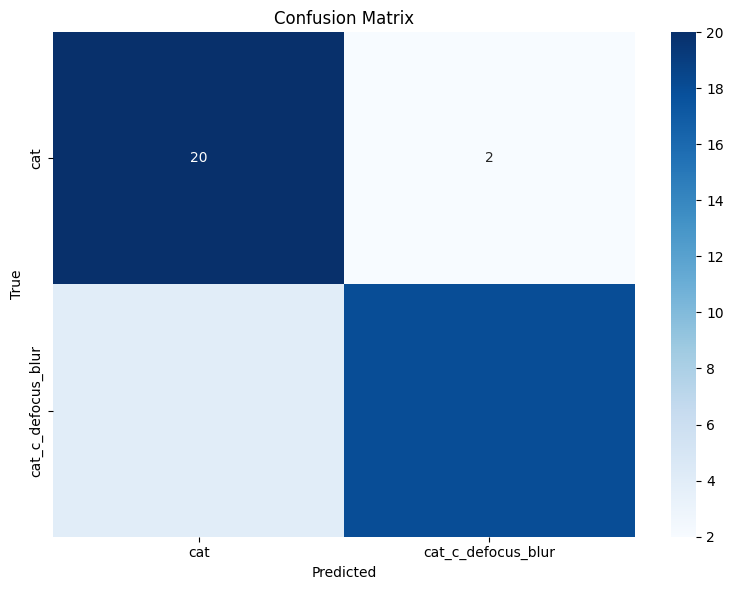

In [111]:
import matplotlib.pyplot as plt  
import seaborn as sns  
from sklearn.metrics import confusion_matrix  

# Calcular la matriz de confusión  
cm = confusion_matrix(all_labels, all_predictions)  

# Verificar la matriz de confusión  
print("Matriz de Confusión:")  
print(cm)  

# Visualizar la matriz de confusión  
plt.figure(figsize=(8, 6))  
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names_test, yticklabels=class_names)  
plt.xlabel('Predicted')  
plt.ylabel('True')  
plt.title('Confusion Matrix')  
plt.tight_layout()  # Asegura que todo el contenido se ajuste dentro de la figura  
plt.show()